In [1]:
import tensorflow as tf
import numpy as np
import gzip
import os

IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
VALIDATION_SIZE = 5000

data_path = "./data"
train_data_path = os.path.join(data_path, "train-images-idx3-ubyte.gz")
train_label_path = os.path.join(data_path, "train-labels-idx1-ubyte.gz")
test_data_path = os.path.join(data_path, "t10k-images-idx3-ubyte.gz")
test_label_path = os.path.join(data_path, "t10k-labels-idx1-ubyte.gz")
print(train_data_path)

./data/train-images-idx3-ubyte.gz


In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data
    
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [3]:
train_data = extract_data(train_data_path, 60000)
test_data = extract_data(test_data_path, 10000)
train_labels = extract_labels(train_label_path, 60000)
test_labels = extract_labels(test_label_path, 10000)

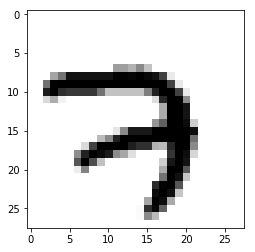

In [4]:
validation_data = train_data[:VALIDATION_SIZE]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:]
train_labels = train_labels[VALIDATION_SIZE:]

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
digital = train_data[0].reshape(28, 28)
plt.imshow(digital, cmap=matplotlib.cm.binary, interpolation="nearest")

In [5]:
train_labels[0]

7

In [6]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_ksize = 2
pool3_stride = 2
pool3_pad = "VALID"
pool3_fmaps = 64

n_fc1 = 64
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, channels], name="X")
#     X_reshaped = tf.reshape(X, shape=[-1, IMAGE_SIZE, IMAGE_SIZE, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    
with tf.name_scope("conv1"):
    conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                        strides=conv1_stride, padding=conv1_pad,
                        activation=tf.nn.relu)
    
with tf.name_scope("conv2"):
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                        strides=conv2_stride, padding=conv2_pad,
                        activation=tf.nn.relu)

with tf.name_scope("pool3"):
#     pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3 = tf.layers.max_pooling2d(conv2, pool_size=pool3_ksize, strides=pool3_stride,
                                    padding=pool3_pad, name="pool3")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs)
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.


In [7]:
n_epochs = 10
batch_size = 100
n_batches = len(train_labels) // batch_size

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(len(train_labels), size=batch_size)
    X_batch = train_data[indices]
    y_batch = train_labels[indices]
    return X_batch, y_batch

In [8]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size)
#             X_batch = np.reshape(X_batch, [-1, n_inputs])
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_validation = accuracy.eval(feed_dict={X: validation_data, y: validation_labels})

        print("Epoch:", epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_validation)
        
        save_path = saver.save(sess, "./my_mnist_model")
    
    acc_test = accuracy.eval(feed_dict={X: test_data, y: test_labels})
    print("Final test accuracy:", acc_test)

Epoch: 0 Train accuracy: 1.0 Validation accuracy: 0.9772
Epoch: 1 Train accuracy: 0.99 Validation accuracy: 0.982
Epoch: 2 Train accuracy: 1.0 Validation accuracy: 0.9852
Epoch: 3 Train accuracy: 0.99 Validation accuracy: 0.9852
Epoch: 4 Train accuracy: 1.0 Validation accuracy: 0.9864
Epoch: 5 Train accuracy: 1.0 Validation accuracy: 0.9856
Epoch: 6 Train accuracy: 0.99 Validation accuracy: 0.9872
Epoch: 7 Train accuracy: 1.0 Validation accuracy: 0.9868
Epoch: 8 Train accuracy: 1.0 Validation accuracy: 0.986
Epoch: 9 Train accuracy: 1.0 Validation accuracy: 0.99
Final test accuracy: 0.9906
